<a href="https://colab.research.google.com/github/503N-project-RC/model-training/blob/main/game_rec_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAME RECOMMENDATION SYSTEM

## PREPROCESSING

In [ ]:
import os
import json
import sys
import warnings
import pandas as pd
!pip install numpy==1.26.4
import numpy as np
from google.colab import drive, files
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix, csr_matrix

!pip install lightfm optuna
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k

import optuna

!pip install gensim
from gensim.models import Word2Vec


In [ ]:
drive.mount('/content/drive')
drive_base_path = '/content/drive/My Drive/503Nproj/game-rec'
file_path = os.path.join(drive_base_path, 'synthetic_training_data.json')

with open(file_path, 'r') as file:
    data = json.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# lists initialized for interaction matrix
player_ids = []
game_ids = []
hours_played = []

# lists initialized for game features
game_features = {}

In [ ]:
# data processing
for player, details in data.items():
    for game_id, game_data in details["games"].items():
        # interaction matrix
        player_ids.append(player)
        game_ids.append(game_id)
        hours_played.append(game_data["hours"])

        # collection of game features
        if game_id not in game_features:
            game_features[game_id] = {
                "rating_ratio": game_data["rating_ratio"],
                "price": float(game_data["price"]),
                "genre": game_data["genre"],
                "tags": game_data["tags"]
            }

In [ ]:
# creation of interaction matrix
player_idx = {player: i for i, player in enumerate(set(player_ids))}
game_idx = {game: i for i, game in enumerate(set(game_ids))}
rows = [player_idx[p] for p in player_ids]
cols = [game_idx[g] for g in game_ids]
data = hours_played
interaction_matrix = coo_matrix((data, (rows, cols)), shape=(len(player_idx), len(game_idx))).tocsr()

sparsity = 1.0 - (interaction_matrix.nnz / float(interaction_matrix.shape[0] * interaction_matrix.shape[1]))
print(f"Sparsity: {sparsity:.2%}")

Sparsity: 93.45%


In [ ]:
# game features ->> DataFrame
game_df = pd.DataFrame.from_dict(game_features, orient='index')

In [ ]:
# Word2Vec embedding

tag_sentences = list(game_df['tags'].apply(lambda x: x if isinstance(x, list) else []))
word2vec = Word2Vec(sentences=tag_sentences, vector_size=50, window=5, min_count=1, workers=4)

print(tag_sentences[10:15])

def get_embedding(tags):
    vectors = [word2vec.wv[tag] for tag in tags if tag in word2vec.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(50)

game_df['tag_embedding'] = game_df['tags'].apply(get_embedding)


[['Free to Play', 'Battle Royale', 'Multiplayer', 'FPS', 'Shooter', 'First-Person', 'PvP', 'Action', 'Hero Shooter', 'Team-Based', 'Tactical', 'Sci-fi', 'Survival', 'Loot', 'Co-op', 'Character Customization', 'Funny', 'Lore-Rich', 'Cyberpunk', 'Cinematic'], ['Free to Play', 'FPS', 'Multiplayer', 'Singleplayer', 'Shooter', 'Action', 'First-Person', 'Open World', 'Sci-fi', 'Co-op', 'PvP', 'Competitive', 'Story Rich', 'Space', 'Adventure', 'Aliens', 'Lore-Rich', 'Cinematic', 'Atmospheric', 'Soundtrack'], ['Free to Play', 'Battle Royale', 'Shooter', 'Multiplayer', 'Survival', 'FPS', 'Action', 'Massively Multiplayer', 'Third-Person Shooter', 'Early Access', 'Singleplayer', 'PvP', 'Open World', 'Co-op', '3D', 'Tactical', 'Violent', 'Gore', 'MOBA', 'First-Person'], ['Open World', 'Extraction Shooter', 'Multiplayer', 'Atmospheric', 'Tactical', 'FPS', 'Perma Death', 'Western', 'PvP', 'Shooter', 'Horror', 'Online Co-Op', 'Survival Horror', 'Co-op', 'Difficult', 'Battle Royale', 'Team-Based', 'Ac

In [ ]:
print("Word2vec vector size = ", word2vec.vector_size)
print(game_df)

Word2vec vector size =  50
         rating_ratio   price  \
1203220         2.363     0.0   
433850          1.258     0.0   
250900         36.967   899.0   
1063730         2.188  4199.0   
582010          7.299  2999.0   
...               ...     ...   
255710         13.356   299.0   
289070          6.586   599.0   
438100          3.089     0.0   
108600         16.160  1099.0   
8930           22.865  2999.0   

                                                     genre  \
1203220         [Action, Adventure, Massively Multiplayer]   
433850   [Action, Adventure, Free To Play, Massively Mu...   
250900                                            [Action]   
1063730    [Action, Adventure, Massively Multiplayer, RPG]   
582010                                            [Action]   
...                                                    ...   
255710                              [Simulation, Strategy]   
289070                                          [Strategy]   
438100   [Adventur

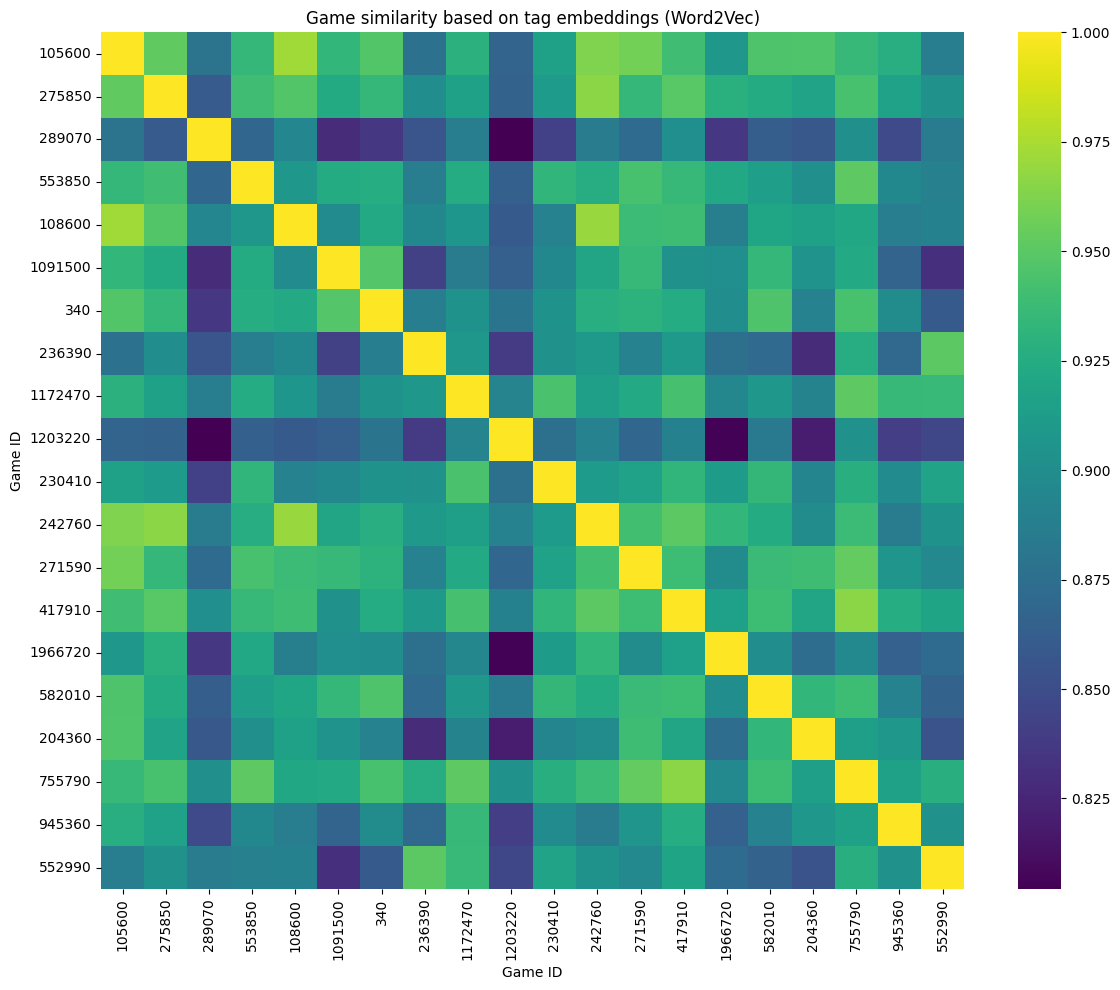

In [ ]:
# select small sample of games to visualize
sample_games = game_df.sample(20, random_state=42)
sample_embeddings = np.vstack(sample_games['tag_embedding'].values)

# compute cosine similarity matrix
similarity_matrix = cosine_similarity(sample_embeddings)

# plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, annot=False, cmap='viridis', xticklabels=sample_games.index, yticklabels=sample_games.index)
plt.title("Game similarity based on tag embeddings (Word2Vec)")
plt.xlabel("Game ID")
plt.ylabel("Game ID")
plt.tight_layout()
plt.show()


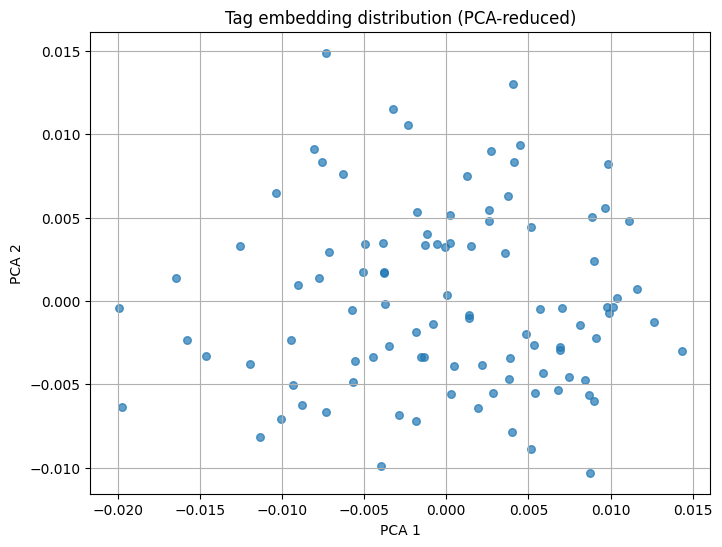

In [ ]:
tag_embeddings = np.vstack(game_df['tag_embedding'].values)

# PCA for 2D projection
pca = PCA(n_components=2)
reduced = pca.fit_transform(tag_embeddings)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], s=30, alpha=0.7)
plt.title("Tag embedding distribution (PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


In [ ]:
# drop original lists
game_df.drop(columns=['genre', 'tags'], inplace=True)

# price & rating ratio normalization
scaler = MinMaxScaler()
game_df[['rating_ratio', 'price']] = scaler.fit_transform(game_df[['rating_ratio', 'price']])

print("Interaction matrix shape:", interaction_matrix.shape)
print("Game features shape:", game_df.shape)

Interaction matrix shape: (50000, 99)
Game features shape: (99, 3)


In [ ]:
# ensure embeddings are expanded into separate numerical columns
game_embeddings = np.vstack(game_df['tag_embedding'].values)

# drop old embedding column
game_df = game_df.drop(columns=['tag_embedding'])

# ensure all columns are numerical
game_feature_matrix = np.hstack([game_df.to_numpy(), game_embeddings])

print("Game features shape:", game_feature_matrix.shape)  # expecting (99, 52) = 50-dim Word2Vec & 2 other features

Game features shape: (99, 52)


In [ ]:
def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    components = trial.suggest_int("components", 40, 120)
    item_alpha = trial.suggest_loguniform("item_alpha", 1e-6, 1e-2)
    user_alpha = trial.suggest_loguniform("user_alpha", 1e-6, 1e-2)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.0001, 0.005)


    model = LightFM(loss=loss, no_components=components, item_alpha=item_alpha, user_alpha=user_alpha, learning_rate=learning_rate)
    model.fit(train, epochs=10, num_threads=4, item_features=csr_matrix(game_feature_matrix))

    test_precision = precision_at_k(model, test, k=5, item_features=csr_matrix(game_feature_matrix)).mean()
    return test_precision

In [ ]:
# train-test split (80-20)
train, test = random_train_test_split(interaction_matrix, test_percentage=0.2)

# optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2025-04-04 20:25:09,492] A new study created in memory with name: no-name-1efb7de4-8cee-4e29-9930-046d75f44b03
[I 2025-04-04 20:29:14,031] Trial 0 finished with value: 0.019806407392024994 and parameters: {'loss': 'warp', 'components': 101, 'item_alpha': 3.117815597654561e-05, 'user_alpha': 4.493555926661294e-05, 'learning_rate': 0.000593657604175349}. Best is trial 0 with value: 0.019806407392024994.
[I 2025-04-04 20:32:24,621] Trial 1 finished with value: 0.023056579753756523 and parameters: {'loss': 'bpr', 'components': 83, 'item_alpha': 7.091244482417398e-06, 'user_alpha': 1.6375891638174376e-06, 'learning_rate': 0.0006288141985418372}. Best is trial 1 with value: 0.023056579753756523.
[I 2025-04-04 20:34:09,640] Trial 2 finished with value: 0.019953647628426552 and parameters: {'loss': 'warp', 'components': 43, 'item_alpha': 1.0585301108118993e-05, 'user_alpha': 1.0564163558985326e-06, 'learning_rate': 0.004103103814332838}. Best is trial 1 with value: 0.023056579753756523.
[I 

Best hyperparameters: {'loss': 'bpr', 'components': 78, 'item_alpha': 4.23244048620726e-06, 'user_alpha': 5.18408271040781e-06, 'learning_rate': 0.00020587258200405341}


In [ ]:
# training with best hyperparameters

final_model = LightFM(loss=best_params['loss'], no_components=best_params['components'],
                      item_alpha=best_params['item_alpha'], user_alpha=best_params['user_alpha'], learning_rate=best_params['learning_rate'])

game_feature_matrix = csr_matrix(game_feature_matrix)

final_model.fit(train, epochs=20, num_threads=4, item_features=game_feature_matrix)

In [ ]:
# model evaluation
train_precision = precision_at_k(final_model, train, k=5, item_features=game_feature_matrix).mean()
test_precision = precision_at_k(final_model, test, k=5, item_features=game_feature_matrix).mean()
print(f"Train precision at k=5: {train_precision:.4f}")
print(f"Test precision at k=5: {test_precision:.4f}")

Train precision at k=5: 0.0649
Test precision at k=5: 0.0231


In [ ]:
# recommend games
def recommend_games(player_id, model, interaction_matrix, game_df, top_n=5):
    scores = model.predict(player_id, np.arange(interaction_matrix.shape[1]), item_features=game_feature_matrix)
    top_games = np.argsort(-scores)[:top_n]  # retrieve top N game indices
    recommended_games = [list(game_df.index)[i] for i in top_games]

    return recommended_games

player_to_recommend = 34645  # example: player 0
recommended_games = recommend_games(player_to_recommend, final_model, interaction_matrix, game_df)
print("Recommended game IDs:", recommended_games)

Recommended game IDs: ['2358720', '1938090', '1063730', '1086940', '899770']


In [ ]:
print("Interaction matrix Shape:", interaction_matrix.shape)
print("Game features Shape:", game_df.shape)

Interaction matrix Shape: (50000, 99)
Game features Shape: (99, 2)


In [ ]:
from lightfm.evaluation import recall_at_k

train_recall = recall_at_k(final_model, train, k=5, item_features=game_feature_matrix).mean()
test_recall = recall_at_k(final_model, test, k=5, item_features=game_feature_matrix).mean()

print(f"Train Recall at k=5: {train_recall:.4f}")
print(f"Test Recall at k=5: {test_recall:.4f}")


Train Recall at k=5: 0.0624
Test Recall at k=5: 0.0654


In [ ]:
from lightfm.evaluation import reciprocal_rank

train_mrr = reciprocal_rank(final_model, train, item_features=game_feature_matrix).mean()
test_mrr = reciprocal_rank(final_model, test, item_features=game_feature_matrix).mean()

print(f"Train MRR: {train_mrr:.4f}")
print(f"Test MRR: {test_mrr:.4f}")


Train MRR: 0.1840
Test MRR: 0.0872


In [ ]:
all_recommendations = set()
for player_id in range(100):
    recommended = recommend_games(player_id, final_model, interaction_matrix, game_df)
    all_recommendations.update(recommended)

print(f"Total unique recommended games: {len(all_recommendations)}")

Total unique recommended games: 5


In [ ]:
!pip install huggingface_hub transformers
from huggingface_hub import login
login()

In [ ]:
import joblib
import os

model_path = "game-rec-model"
if not os.path.exists(model_path):
    os.makedirs(model_path)

joblib.dump(final_model, os.path.join(model_path, 'game-rec.pkl'))


['game-rec-model/game-rec.pkl']

In [ ]:
from huggingface_hub import HfApi
repo_id = "reemchaaban/game-rec"

api = HfApi()
api.create_repo(repo_id=repo_id, exist_ok=True)

api.upload_file(
    path_or_fileobj=os.path.join(model_path, 'game-rec.pkl'),
    path_in_repo="game-rec.pkl",
    repo_id=repo_id,
)


game-rec.pkl:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reemchaaban/game-rec/commit/d2c21b3d553965ba4e4a64329d91d9ed6968c5db', commit_message='Upload game-rec.pkl with huggingface_hub', commit_description='', oid='d2c21b3d553965ba4e4a64329d91d9ed6968c5db', pr_url=None, repo_url=RepoUrl('https://huggingface.co/reemchaaban/game-rec', endpoint='https://huggingface.co', repo_type='model', repo_id='reemchaaban/game-rec'), pr_revision=None, pr_num=None)